# Convergence of the system for different initial conditions
This notebook aims to check whether the system converges when its initial conditions are varied.

In [1]:
import numpy as np
import configparser
import os
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D #for 3D scatter
import matplotlib.pyplot as plt
from pyDOE import lhs #for LHS sampling

### Function to retrieve information from the configuration file

In [2]:
def extract_values(section_name, config):
    values = []
    if section_name in config:
        for key, value in config[section_name].items():
            values.append(float(value))
    else:
        print(f'Section "{section_name}" is not in the configuration file.')
    return values

### One-step update in the system's evolution

In [3]:
def one_step(t, dt, dx, H, C, M, N, D, R, H_new, C_new, M_new, N_new, D_new, R_new, H_i, C_i, M_i, par, diffusion, boundary):

    k1, k2, k3, k4, k5, k6, d_H, d_C, d_M, d_D, sigma, m, h = par
    D_H, D_C, D_M = diffusion

    for i in range(len(H)):

        ev_H(i, dt, dx, D_H, d_H, k1, H_i, H, M, D, H_new, boundary)
        ev_C(i, dt, dx, D_C, d_C, k2, C_i, C, H, D, C_new, boundary)
        ev_M(i, dt, dx, D_M, d_M, k3, M_i, M, D, M_new, boundary)
        ev_N(i, t, dt, sigma, m, h, k4, k5, R, C, N, N_new)
        ev_D(i, t, dt, d_D, sigma, m, h, k5, k6, C, M, N, D, D_new)
        ev_R(i, dt, d_D, k4, k6, M, D, R, R_new)

### Damage function

In [4]:
def damage(t, sigma, m, h):

    if t==0 or t <=1e-14:
        return 0.
    else:
       return h / (t * sigma * np.sqrt(2*np.pi)) * np.exp(-(np.log(t) - m)**2 / (2. * sigma**2))

### Diffusion functions

In [5]:
def diff_H(i, dx, D_H, H, precision=14):
    if i == 0:
        diff = H[i+1] - H[i]
    elif i == len(H) - 1:
        diff = H[i-1] - H[i]
    else:
        diff = H[i+1] + H[i-1] - 2 * H[i]
    
    if round(diff / (abs(H[i]) + 1e-14), precision) == 0:
        return 0
    else:
        return D_H / dx * diff

def diff_C(i, dx, D_C, C, precision=14):
    if i == 0:
        diff = C[i+1] - C[i]
    elif i == len(C) - 1:
        diff = C[i-1] - C[i]
    else:
        diff = C[i+1] + C[i-1] - 2 * C[i]
    
    if round(diff / (abs(C[i]) + 1e-14), precision) == 0:
        return 0
    else:
        return D_C / dx * diff

def diff_M(i, dx, D_M, M, precision=14):
    if i == 0:
        diff = M[i+1] - M[i]
    elif i == len(M) - 1:
        diff = M[i-1] - M[i]
    else:
        diff = M[i+1] + M[i-1] - 2 * M[i]
    
    if round(diff / (abs(M[i]) + 1e-14), precision) == 0:
        return 0
    else:
        return D_M / dx * diff

### Evolution of the immune cells
Possible boundary conditions:
- periodic
- evolving_sym: the rightmost and leftmost cells are initialized in the same way and evolve like the inner ones
- evolving_asym: the rightmost and leftmost cells are initialized differently and evolve like the inner ones
- fixed_sym: he rightmost and leftmost cells are initialized in the same way and cannot evolve
- fixed_asym: the rightmost and leftmost cells are initialised differently and cannot evolve

In [6]:
def ev_H(i, dt, dx, D_H, d_H, k1, H_i, H, M, D, H_new, boundary):
    
    if boundary in ['evolving_sym', 'evolving_asym']:
        H_new[i] = H[i] + dt * (diff_H(i, dx, D_H, H) + k1 * D[i] * M[i] + d_H * (H_i[i] - H[i]))
    elif boundary in ['fixed_sym', 'fixed_asym']:
        if i==0 or i==len(H)-1:
            H_new[i] = H[i]
        else:
            H_new[i] = H[i] + dt * (diff_H(i, dx, D_H, H) + k1 * D[i] * M[i] + d_H * (H_i[i] - H[i]))
    elif boundary=='periodic':
        if i==0:
            H_new[i] = H[i] + dt * (D_H / dx * (H[i+1] + H[len(H)-1] - 2*H[i]) + k1 * D[i] * M[i] + d_H * (H_i[i] - H[i]))
        elif i==len(H)-1:
            H_new[i] = H[i] + dt * (D_H / dx * (H[0] + H[i-1] - 2*H[i]) + k1 * D[i] * M[i] + d_H * (H_i[i] - H[i]))
        else:
            H_new[i] = H[i] + dt * (D_H / dx * (H[i+1] + H[i-1] - 2*H[i]) + k1 * D[i] * M[i] + d_H * (H_i[i] - H[i]))
    else:
        print('Cannot perform computation without some specified boundary conditions')

def ev_C(i, dt, dx, D_C, d_C, k2, C_i, C, H, D, C_new, boundary):
    
    if boundary in ['evolving_sym', 'evolving_asym']:
        C_new[i] = C[i] + dt * (diff_C(i, dx, D_C, C) + k2 * D[i] * H[i] + d_C * (C_i[i] - C[i]))
    elif boundary in ['fixed_sym', 'fixed_asym']:
        if i==0 or i==len(C)-1:
            C_new[i] = C[i]
        else:
            C_new[i] = C[i] + dt * (diff_C(i, dx, D_C, C) + k2 * D[i] * H[i] + d_C * (C_i[i] - C[i]))
    elif boundary=='periodic':
        if i==0:
            C_new[i] = C[i] + dt * (D_C / dx * (C[i+1] + C[len(C)-1] - 2*C[i]) + k2 * D[i] * H[i] + d_C * (C_i[i] - C[i]))
        elif i==N_cells-1:
            C_new[i] = C[i] + dt * (D_C / dx * (C[0] + C[i-1] - 2*C[i]) + k2 * D[i] * H[i] + d_C * (C_i[i] - C[i]))
        else:
            C_new[i] = C[i] + dt * (D_C / dx * (C[i+1] + C[i-1] - 2*C[i]) + k2 * D[i] * H[i] + d_C * (C_i[i] - C[i]))
    else:
        print('Cannot perform computation without some specified boundary conditions')
   
def ev_M(i, dt, dx, D_M, d_M, k3, M_i, M, D, M_new, boundary):

    if boundary in ['evolving_sym', 'evolving_asym']:
        M_new[i] = M[i] + dt * (diff_M(i, dx, D_M, M) + k3 * D[i] * M[i] + d_M * (M_i[i] - M[i]))
    elif boundary in ['fixed_sym', 'fixed_asym']:
        if i==0 or i==len(M)-1:
            M_new[i] = M[i]
        else:
            M_new[i] = M[i] + dt * (diff_M(i, dx, D_M, M) + k3 * D[i] * M[i] + d_M * (M_i[i] - M[i]))
    elif boundary=='periodic':
        if i==0:
            M_new[i] = M[i] + dt * (D_M / dx * (M[i+1] + M[len(M)-1] - 2*M[i]) + k3 * D[i] * M[i] + d_M * (M_i[i] - M[i]))
        elif i==len(M)-1:
            M_new[i] = M[i] + dt * (D_M / dx * (M[0] + M[i-1] - 2*M[i]) + k3 * D[i] * M[i] + d_M * (M_i[i] - M[i]))
        else:
            M_new[i] = M[i] + dt * (D_M / dx * (M[i+1] + M[i-1] - 2*M[i]) + k3 * D[i] * M[i] + d_M * (M_i[i] - M[i]))
    else:
        print('Cannot perform computation without some specified boundary conditions')

### Evolution of the composition of muscle tissue

In [7]:
def ev_N(i, t, dt, sigma, m, h, k4, k5, R, C, N, N_new):
    N_new[i] = N[i] + dt * (k4 * R[i] - N[i] * (k5 * C[i] + damage(t, sigma, m, h)))
    
def ev_D(i, t, dt, d_D, sigma, m, h, k5, k6, C, M, N, D, D_new):
    D_new[i] = D[i] + dt * (N[i] * (k5 * C[i] + damage(t, sigma, m, h)) - D[i] * (k6 * M[i] + d_D))

def ev_R(i, dt, d_D, k4, k6, M, D, R, R_new):
    R_new[i] = R[i] + dt * (D[i] * (k6 * M[i] + d_D) - k4 * R[i])

### Save the output to a .csv file

In [8]:
def save_to_csv(output_list, column_name, directory, file_name):
    os.makedirs(directory, exist_ok=True)
    
    file_path = os.path.join(directory, file_name)
    
    try:
        df = pd.read_csv(file_path)
    except FileNotFoundError:
        df = pd.DataFrame()

    df[column_name] = output_list
    
    df.to_csv(file_path, index=False)

### Define which kind of state variable one is working with (tissue or immune cells)

This function recognises whether or not the given variable is a type of fibre in muscle tissue.

In [9]:
def is_muscle_tissue(var):
    if var in ['N', 'D', 'R']:
        return True
    else:
        return False

### Simulation
For clarity, in the following cell, the coordinates of the initial condition for each state variable can be changed one at a time. Three different checkpoints for the evolution are extracted from the configuration file: t_intermediate_1, t_intermediate_2 and t_max. These checkpoints should be chosen to be sufficiently large to ensure the system is close to its stationary state. For a given initial condition, convergence is considered reached if both the absolute difference between the values of H at t_intermediate_2 and t_intermediate_1, and the absolute difference between the values of H at t_intermediate_2 and t_max are smaller than 1.

In [10]:
#Extract the needed parameters from the configuration file
config = configparser.ConfigParser()
config.read('config.ini')

#Parameters
i_c = extract_values('initial_conditions', config)
i_c_stored = i_c.copy() #keeps track of the initial condition specified in config.ini
par = extract_values('parameters', config)
diffusion = extract_values('diff_coeff', config)
sim = extract_values('simulation_par', config)

boundary = 'periodic'

dt, t_min, t_intermediate_1, t_intermediate_2, t_max, dx, N_cells = sim
N_cells = int(N_cells)

'''The broader values from the paper are as follows, but they can be adjusted to focus on a region of particular interest'''
bounds = [(0, 4500), (0, 450), (0, 100000), (0, 100), (0, 100), (0, 100)]
num_samples = [101, 101, 101, 101, 101, 101]
var = 'M'
is_percentage = is_muscle_tissue(var)

n_vars = 6
labels = ['CD4_T_cells', 'CD8_T_cells', 'macrophages', 'normal_fibres', 'damaged_fibres', 'regenerating_fibres']
var_map = {
    'H': 0,
    'C': 1,
    'M': 2,
    'N': 3, 
    'D': 4, 
    'R': 5
}

#Sample the chosen state variable in the predefined bounds
sample = np.linspace(*bounds[var_map[var]], num_samples[var_map[var]])

time_steps = np.linspace(t_min, t_max, int((t_max - t_min) / dt) + 1)

remaining_vars = []    
for choice in var_map.keys():
    if choice != var:
        remaining_vars.append(choice)

i_c_second, i_c_third = [], []

#To store the value at t_max for each state variable for every initial condition
H_values = []
C_values = []
M_values = []
N_values = []
D_values = []
R_values = []

initial_conditions = []
for i in range(num_samples[var_map[var]]):
    #print(i)
#At each iteration, the system is reset to its original state and the initial condition is then updated
    i_c = i_c_stored.copy()
    i_c[var_map[var]] = sample[i]

    initial_conditions.append(i_c.copy())

    '''Mass conservation must be maintained in the initial conditions,
so if N_i, D_i or R_i are changed, the others must be adjusted accordingly'''
    if is_percentage:
        second, third = remaining_vars[3:5] #the last two variables are the ones referring to muscle tissue
        if 100 - i_c[var_map[var]] - i_c[var_map[second]] >= 0:
            i_c[var_map[third]] = 100. - i_c[var_map[var]] - i_c[var_map[second]]
            i_c_second.append(i_c[var_map[second]])
            i_c_third.append(i_c[var_map[third]])
        elif 100 - i_c[var_map[var]] - i_c[var_map[third]] >= 0:
            i_c[var_map[second]] = 100. - i_c[var_map[var]] - i_c[var_map[third]]
            i_c_second.append(i_c[var_map[second]])
            i_c_third.append(i_c[var_map[third]])
        else:
            i_c[var_map[second]] = 100. - i_c[var_map[var]]
            i_c[var_map[third]] = 0.
            i_c_second.append(i_c[var_map[second]])
            i_c_third.append(i_c[var_map[third]])

#State variables, initial conditions and update lists
    H, C, M, N, D, R = [[i_c[k]] * N_cells for k in range(n_vars)]
    H_i, C_i, M_i, N_i, D_i, R_i = [[i_c[k]] * N_cells for k in range(n_vars)]
    H_new, C_new, M_new, N_new, D_new, R_new = [[i_c[k]] * N_cells for k in range(n_vars)]

    for time in time_steps:
        
        one_step(time, dt, dx, H, C, M, N, D, R, 
                H_new, C_new, M_new, N_new, D_new, R_new, 
                H_i, C_i, M_i, par, diffusion, boundary)

        H, C, M, N, D, R = H_new.copy(), C_new.copy(), M_new.copy(), N_new.copy(), D_new.copy(), R_new.copy()

        if time in [t_intermediate_1, t_intermediate_2, t_max]:
#For every initial condition the output of the simulation at t_max in the first cell (representative of all) is stored
            H_values.append(H_new[0])
            C_values.append(C_new[0])
            M_values.append(M_new[0])
            N_values.append(N_new[0])
            D_values.append(D_new[0])
            R_values.append(R_new[0])

first_H = np.array([float(value) for value in H_values[0::3]])
first_C = np.array([float(value) for value in C_values[0::3]])
first_M = np.array([float(value) for value in M_values[0::3]])
first_N = np.array([float(value) for value in N_values[0::3]])
first_D = np.array([float(value) for value in D_values[0::3]])
first_R = np.array([float(value) for value in R_values[0::3]])

second_H = np.array([float(value) for value in H_values[1::3]])
second_C = np.array([float(value) for value in C_values[1::3]])
second_M = np.array([float(value) for value in M_values[1::3]])
second_N = np.array([float(value) for value in N_values[1::3]])
second_D = np.array([float(value) for value in D_values[1::3]])
second_R = np.array([float(value) for value in R_values[1::3]])

final_H = np.array([float(value) for value in H_values[2::3]])
final_C = np.array([float(value) for value in C_values[2::3]])
final_M = np.array([float(value) for value in M_values[2::3]])
final_N = np.array([float(value) for value in N_values[2::3]])
final_D = np.array([float(value) for value in D_values[2::3]])
final_R = np.array([float(value) for value in R_values[2::3]])

directory = f'sample_{var}i/values_at_{t_intermediate_1}_{t_intermediate_2}_and_{t_max}/range_{bounds[var_map[var]][0]}_{bounds[var_map[var]][1]}/'

if is_percentage:
    save_to_csv(sample, f'{var}i_sample', directory, f'sample_{var}.csv')
    save_to_csv(i_c_second, f'{remaining_vars[-2]}i', directory, f'sample_{var}.csv')
    save_to_csv(i_c_third, f'{remaining_vars[-1]}i', directory, f'sample_{var}.csv')
else:
    save_to_csv(sample, f'{var}_dt_{dt}_sample', directory, f'sample_{var}.csv')

save_to_csv(first_H, f'changing_{var}_i_at_{t_intermediate_1}', directory, 'H.csv')
save_to_csv(first_C, f'changing_{var}_i_at_{t_intermediate_1}', directory, 'C.csv')
save_to_csv(first_M, f'changing_{var}_i_at_{t_intermediate_1}', directory, 'M.csv')
save_to_csv(first_N, f'changing_{var}_i_at_{t_intermediate_1}', directory, 'N.csv')
save_to_csv(first_D, f'changing_{var}_i_at_{t_intermediate_1}', directory, 'D.csv')
save_to_csv(first_R, f'changing_{var}_i_at_{t_intermediate_1}', directory, 'R.csv')

save_to_csv(second_H, f'changing_{var}_i_at_{t_intermediate_2}', directory, 'H.csv')
save_to_csv(second_C, f'changing_{var}_i_at_{t_intermediate_2}', directory, 'C.csv')
save_to_csv(second_M, f'changing_{var}_i_at_{t_intermediate_2}', directory, 'M.csv')
save_to_csv(second_N, f'changing_{var}_i_at_{t_intermediate_2}', directory, 'N.csv')
save_to_csv(second_D, f'changing_{var}_i_at_{t_intermediate_2}', directory, 'D.csv')
save_to_csv(second_R, f'changing_{var}_i_at_{t_intermediate_2}', directory, 'R.csv')

save_to_csv(final_H, f'changing_{var}_i_at_{t_max}', directory, 'H.csv')
save_to_csv(final_C, f'changing_{var}_i_at_{t_max}', directory, 'C.csv')
save_to_csv(final_M, f'changing_{var}_i_at_{t_max}', directory, 'M.csv')
save_to_csv(final_N, f'changing_{var}_i_at_{t_max}', directory, 'N.csv')
save_to_csv(final_D, f'changing_{var}_i_at_{t_max}', directory, 'D.csv')
save_to_csv(final_R, f'changing_{var}_i_at_{t_max}', directory, 'R.csv')

condition_1 = np.abs(first_H - second_H) < 1
condition_2 = np.abs(second_H - final_H) < 1
condition = condition_1 & condition_2

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100


Plot the output of the simulation.

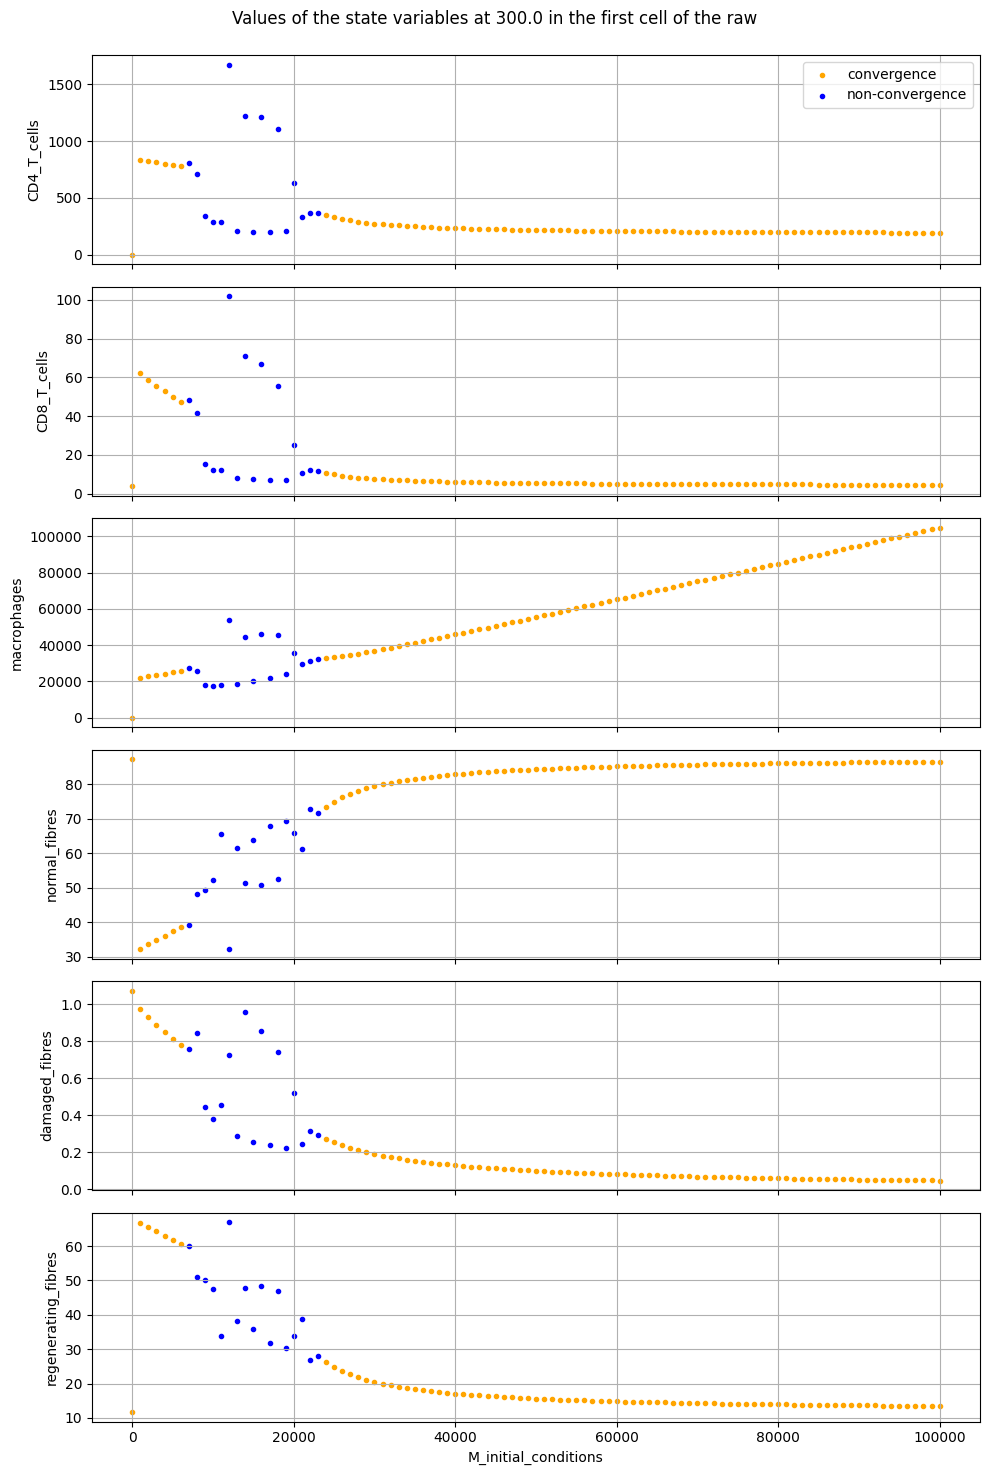

In [11]:
fig, axes = plt.subplots(n_vars, 1, figsize=(10, 15), sharex=True)
final = [final_H, final_C, final_M, final_N, final_D, final_R]

for i in range(n_vars): 
    axes[i].scatter(sample[condition], final[i][condition], label='convergence', color='orange', marker='.')
    axes[i].scatter(sample[~condition], final[i][~condition], label='non-convergence', color='blue', marker='.')
    axes[i].set_ylabel(labels[i])
    axes[i].grid(True)

axes[-1].set_xlabel(f'{var}_initial_conditions')
axes[0].legend()

fig.suptitle(f'Values of the state variables at {t_max} in the first cell of the raw')
plt.tight_layout()
plt.subplots_adjust(top=0.95)

#plt.savefig(f'variable_{var}i_convergence')

plt.show()

### Latin Hypercube Sampling
The LHS algorithm is useful for exploring the entire 5-dimensional phase space. This function can be used to sample initial conditions within a specified region of the phase space. Since we have an additional constraint due to mass conservation, the following function does not actually contain the Latin Hypercube Sampling algorithm in five dimensions.

In [12]:
def LHS_sampling(num_samples):

#Define bounds for variables H, C, M, N; the bound for D is not fixed, it depends on the value of N as D_max = 100 - N
    bounds = np.array([[0, 4500],
                       [0, 450],
                       [0, 100000],
                       [0, 100]])
    min_D = 0.
    min_R = 0.

#5 refers to the dimension of the space
#lhs returns a num_samplesX5 matrix of values between 0 and 1, that need to be rescaled according to bounds
    lhs_samples = lhs(5, samples=num_samples)

#Scaling
    scaled_HCMN = bounds[:, 0] + lhs_samples[:,0:4] * (bounds[:, 1] - bounds[:, 0])
    scaled_D = min_D + lhs_samples[:,4] * (100 - scaled_HCMN[:, 3] - min_D - min_R)

#Calculate R as R = 100 - N - D and ensure its value does not exceed the range (0, 100)
    R = 100 - scaled_HCMN[:,3] - scaled_D
    R = np.clip(R, 0, 100)
    samples = np.column_stack((scaled_HCMN, scaled_D))

#Append R as the sixth dimension    
    sampling = np.column_stack((samples, R))

    return sampling

### Simulation

In the following cell, a number of initial conditions specified by num_samples is extracted from the region of the phase space where  $H \in [0, 4500]$, $C \in [0, 450]$, $M \in [0, 100000]$, $N \in [0, 100]$, $D \in [0, 100]$ and $R \in [0, 100]$. The evolution starting from each of these initial conditions is computed, and a check on the convergence condition is performed. 

In [29]:
num_samples = 750
#Extract num_samples initial conditions using the LHS algorithm
initial_conditions = LHS_sampling(num_samples)

H_values = []
C_values = []
M_values = []
N_values = []
D_values = []
R_values = []

for i in range(num_samples):
    i_c = initial_conditions[i]
    print(i_c)
    
    H, C, M, N, D, R = [[i_c[k]] * N_cells for k in range(n_vars)]
    H_i, C_i, M_i, N_i, D_i, R_i = [[i_c[k]] * N_cells for k in range(n_vars)]
    H_new, C_new, M_new, N_new, D_new, R_new = [[i_c[k]] * N_cells for k in range(n_vars)]

    for time in time_steps:
        
        one_step(time, dt, dx, H, C, M, N, D, R, 
                H_new, C_new, M_new, N_new, D_new, R_new, 
                H_i, C_i, M_i, par, diffusion, boundary)

        H, C, M, N, D, R = H_new.copy(), C_new.copy(), M_new.copy(), N_new.copy(), D_new.copy(), R_new.copy()

        if time in [t_intermediate_1, t_intermediate_2, t_max]:
#The state of the system at each checkpoint is stored for the first cell of the row, which is representative of the entire system.
            H_values.append(H_new[0])
            C_values.append(C_new[0])
            M_values.append(M_new[0])
            N_values.append(N_new[0])
            D_values.append(D_new[0])
            R_values.append(R_new[0])

#First checkpoint
first_H = np.array([float(value) for value in H_values[0::3]])
first_C = np.array([float(value) for value in C_values[0::3]])
first_M = np.array([float(value) for value in M_values[0::3]])
first_N = np.array([float(value) for value in N_values[0::3]])
first_D = np.array([float(value) for value in D_values[0::3]])
first_R = np.array([float(value) for value in R_values[0::3]])

#Second checkpoint
second_H = np.array([float(value) for value in H_values[1::3]])
second_C = np.array([float(value) for value in C_values[1::3]])
second_M = np.array([float(value) for value in M_values[1::3]])
second_N = np.array([float(value) for value in N_values[1::3]])
second_D = np.array([float(value) for value in D_values[1::3]])
second_R = np.array([float(value) for value in R_values[1::3]])

#End of the evolution
final_H = np.array([float(value) for value in H_values[2::3]])
final_C = np.array([float(value) for value in C_values[2::3]])
final_M = np.array([float(value) for value in M_values[2::3]])
final_N = np.array([float(value) for value in N_values[2::3]])
final_D = np.array([float(value) for value in D_values[2::3]])
final_R = np.array([float(value) for value in R_values[2::3]])

condition_1 = np.abs(first_H - second_H) < 1
condition_2 = np.abs(second_H - final_H) < 1
condition = condition_1 & condition_2

i_c_H = np.array([row[0] for row in initial_conditions])
i_c_C = np.array([row[1] for row in initial_conditions])
i_c_M = np.array([row[2] for row in initial_conditions])
i_c_N = np.array([row[3] for row in initial_conditions])
i_c_D = np.array([row[4] for row in initial_conditions])
i_c_R = np.array([row[5] for row in initial_conditions])

directory = f'{num_samples}_LHS_sample/values_at_{t_intermediate_1}_{t_intermediate_2}_and_{t_max}/standard_bounds_dt_{dt}/'

save_to_csv(i_c_H, 'H_i', directory, 'LHS_sampling.csv')
save_to_csv(i_c_C, 'C_i', directory, 'LHS_sampling.csv')
save_to_csv(i_c_M, 'M_i', directory, 'LHS_sampling.csv')
save_to_csv(i_c_N, 'N_i', directory, 'LHS_sampling.csv')
save_to_csv(i_c_D, 'D_i', directory, 'LHS_sampling.csv')
save_to_csv(i_c_R, 'R_i', directory, 'LHS_sampling.csv')

save_to_csv(first_H, f'first_checkpoint_{t_intermediate_1}', directory, 'H.csv')
save_to_csv(first_C, f'first_checkpoint_{t_intermediate_1}', directory, 'C.csv')
save_to_csv(first_M, f'first_checkpoint_{t_intermediate_1}', directory, 'M.csv')
save_to_csv(first_N, f'first_checkpoint_{t_intermediate_1}', directory, 'N.csv')
save_to_csv(first_D, f'first_checkpoint_{t_intermediate_1}', directory, 'D.csv')
save_to_csv(first_R, f'first_checkpoint_{t_intermediate_1}', directory, 'R.csv')

save_to_csv(second_H, f'second_checkpoint_{t_intermediate_2}', directory, 'H.csv')
save_to_csv(second_C, f'second_checkpoint_{t_intermediate_2}', directory, 'C.csv')
save_to_csv(second_M, f'second_checkpoint_{t_intermediate_2}', directory, 'M.csv')
save_to_csv(second_N, f'second_checkpoint_{t_intermediate_2}', directory, 'N.csv')
save_to_csv(second_D, f'second_checkpoint_{t_intermediate_2}', directory, 'D.csv')
save_to_csv(second_R, f'second_checkpoint_{t_intermediate_2}', directory, 'R.csv')

save_to_csv(final_H, f'end_evolution_{t_max}', directory, 'H.csv')
save_to_csv(final_C, f'end_evolution_{t_max}', directory, 'C.csv')
save_to_csv(final_M, f'end_evolution_{t_max}', directory, 'M.csv')
save_to_csv(final_N, f'end_evolution_{t_max}', directory, 'N.csv')
save_to_csv(final_D, f'end_evolution_{t_max}', directory, 'D.csv')
save_to_csv(final_R, f'end_evolution_{t_max}', directory, 'R.csv')

[6.15688418e+02 1.33103126e+02 9.72149051e+04 2.75978921e-01
 8.92987520e+01 1.04252691e+01]


/var/folders/fj/xx8_jc2x0nn7wbdtp17njw600000gn/T/ipykernel_68726/2939845072.py:12: RuntimeWarning: overflow encountered in scalar multiply
  H_new[i] = H[i] + dt * (D_H / dx * (H[i+1] + H[len(H)-1] - 2*H[i]) + k1 * D[i] * M[i] + d_H * (H_i[i] - H[i]))
/var/folders/fj/xx8_jc2x0nn7wbdtp17njw600000gn/T/ipykernel_68726/2939845072.py:31: RuntimeWarning: overflow encountered in scalar multiply
  C_new[i] = C[i] + dt * (D_C / dx * (C[i+1] + C[len(C)-1] - 2*C[i]) + k2 * D[i] * H[i] + d_C * (C_i[i] - C[i]))
/var/folders/fj/xx8_jc2x0nn7wbdtp17njw600000gn/T/ipykernel_68726/2939845072.py:50: RuntimeWarning: overflow encountered in scalar multiply
  M_new[i] = M[i] + dt * (D_M / dx * (M[i+1] + M[len(M)-1] - 2*M[i]) + k3 * D[i] * M[i] + d_M * (M_i[i] - M[i]))
/var/folders/fj/xx8_jc2x0nn7wbdtp17njw600000gn/T/ipykernel_68726/996950287.py:2: RuntimeWarning: overflow encountered in scalar multiply
  N_new[i] = N[i] + dt * (k4 * R[i] - N[i] * (k5 * C[i] + damage(t, sigma, m, h)))
/var/folders/fj/xx8_jc2x

[1.75044143e+03 2.79924859e+02 2.87470584e+04 3.88240217e+01
 4.59086810e+00 5.65851102e+01]
[1.97784901e+03 8.47629633e+01 7.59536873e+04 3.36807652e+01
 2.89468603e+01 3.73723745e+01]
[6.89350346e+02 2.62619583e+02 9.83095327e+04 6.58307266e+01
 2.44881289e+01 9.68114447e+00]


/var/folders/fj/xx8_jc2x0nn7wbdtp17njw600000gn/T/ipykernel_68726/996950287.py:5: RuntimeWarning: invalid value encountered in scalar subtract
  D_new[i] = D[i] + dt * (N[i] * (k5 * C[i] + damage(t, sigma, m, h)) - D[i] * (k6 * M[i] + d_D))
/var/folders/fj/xx8_jc2x0nn7wbdtp17njw600000gn/T/ipykernel_68726/996950287.py:2: RuntimeWarning: invalid value encountered in scalar subtract
  N_new[i] = N[i] + dt * (k4 * R[i] - N[i] * (k5 * C[i] + damage(t, sigma, m, h)))


[2.58500051e+03 2.46434237e+02 1.04424281e+04 9.18420903e+00
 4.91838029e+01 4.16319881e+01]
[3.40441225e+03 2.15477948e+02 4.24949641e+04 7.98113163e+01
 6.33134283e+00 1.38573409e+01]
[3.96403515e+03 1.19146992e+02 4.18403761e+04 5.66672522e+01
 4.43936120e+00 3.88933866e+01]
[4.05590655e+02 2.85882396e+02 3.27327380e+04 5.19709051e+01
 1.71344058e+01 3.08946891e+01]
[2.70475608e+03 3.92396306e+02 9.03290063e+04 9.53303777e+01
 2.61728578e+00 2.05233653e+00]
[1.43340750e+03 4.38540085e+02 2.07521882e+04 8.75511622e+01
 9.77101061e+00 2.67782716e+00]
[2.04240252e+03 1.65566712e+02 5.69021935e+04 5.47161783e+01
 5.84017482e+00 3.94436469e+01]
[1455.74730477  197.58620161  647.52849436   15.97582157   58.36570658
   25.65847185]
[3.48300201e+03 2.44953342e+02 4.98806611e+04 8.72849931e+01
 5.64794668e+00 7.06706025e+00]
[3.09993940e+02 2.46818351e+02 1.19684041e+04 3.89526443e+01
 2.80194686e+00 5.82454089e+01]
[4.27155807e+03 2.73285614e+02 3.73087306e+04 3.86423975e+01
 1.65394714e+01

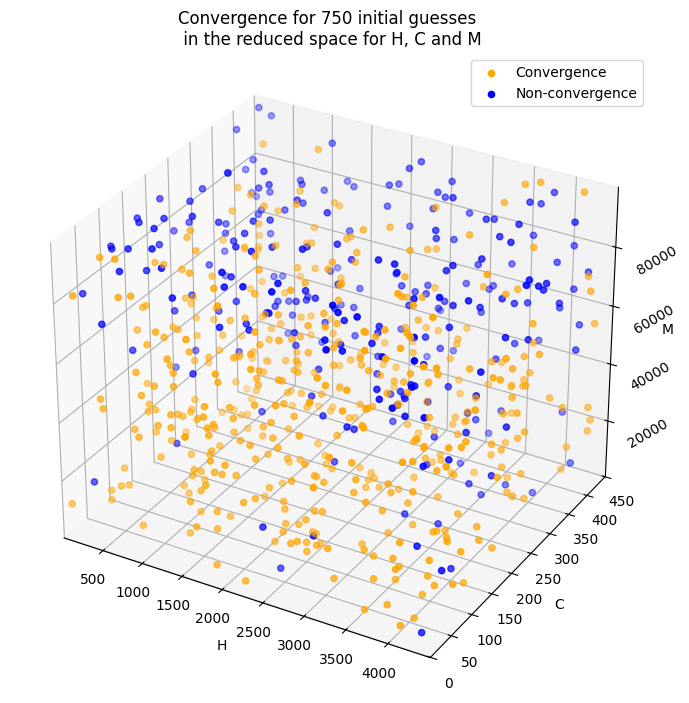

In [30]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

#Plot the initial conditions based on convergence conditions with different colours
ax.scatter(i_c_H[condition], i_c_C[condition], i_c_M[condition], c='orange', marker='o', label='Convergence')
ax.scatter(i_c_H[~condition], i_c_C[~condition], i_c_M[~condition], c='b', marker='o', label='Non-convergence')

ax.set_xlabel('H')
ax.set_ylabel('C')
ax.set_zlabel('M')

ax.set_title(f'Convergence for {num_samples} initial guesses \n in the reduced space for H, C and M')
ax.tick_params(axis='z', pad=10, labelrotation=30)

#Zoom in on the region where the points are
ax.set_xlim([min(i_c_H) - 1, max(i_c_H) + 1])
ax.set_ylim([min(i_c_C) - 1, max(i_c_C) + 1])
ax.set_zlim([min(i_c_M) - 1, max(i_c_M) + 1])

ax.legend()

fig.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)
ax.set_box_aspect([1, 0.9, 0.8])

filepath = directory + 'convergence_in_HCM.png'
#plt.savefig(filepath)

plt.show()

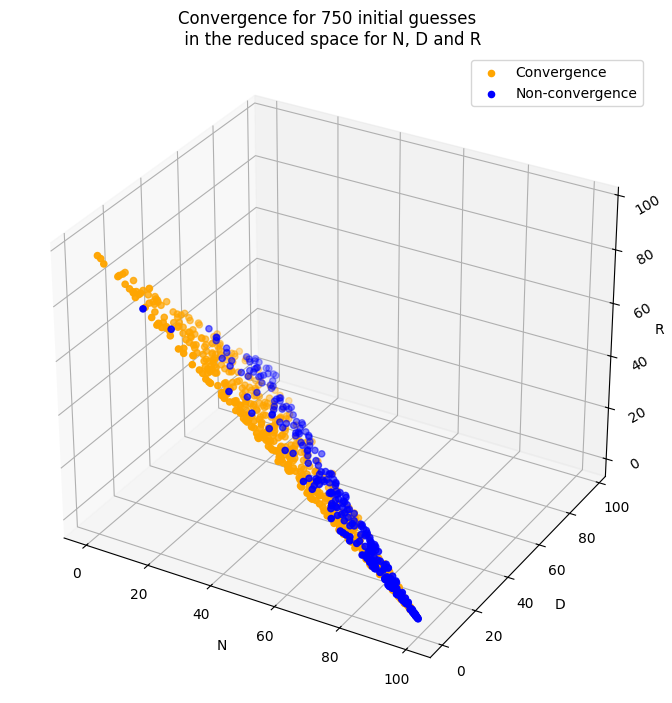

In [31]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(i_c_N[condition], i_c_D[condition], i_c_R[condition], c='orange', marker='o', label='Convergence')
ax.scatter(i_c_N[~condition], i_c_D[~condition], i_c_R[~condition], c='b', marker='o', label='Non-convergence')

ax.set_xlabel('N')
ax.set_ylabel('D')
ax.set_zlabel('R', labelpad=0.5)

ax.set_title(f'Convergence for {num_samples} initial guesses \n in the reduced space for N, D and R')

ax.tick_params(axis='z', pad=5, labelrotation=30)
ax.legend()

fig.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)
ax.set_box_aspect([1, 0.9, 0.8])

filepath = directory + 'convergence_in_NDR.png'
#plt.savefig(filepath)

plt.show()